# Python自动化报表分析

## 1.   基础配置

In [266]:
from AutoGraphing import *

# 想要分析的上市公司代码
ID = '603117'

# 在r后面的引号中写入报表文件所在目录
path = r'E:/18082/Documents/9 CodeProjects/sheet'

# 写入想要的主题色
cm = '#9cc3e5'

# 生成配色方案（下例默认有5种颜色（cl[0]~cl[4]），其中cl[0]即是主题色）
cl = neighborcolor(cm, 5)

## 2.   数据整理

In [264]:
def DataClean(filename):
    df = pd.read_excel(filename, sheet_name='sheet1', header=None)
    df.loc[1, 1] = '会计期间'
    df.columns = df.values.tolist()[1]
    df = df[df['会计期间'].apply(lambda x: x[5:7] == "12")]
    #df = df.set_index('会计期间')
    df = df[df['报表类型'].isin(['A'])].fillna(value=0)
    return df

os.chdir(path)
path_img = path + '/' + ID
if not os.path.exists(path_img):
    os.makedirs(path_img)

BalanceSheet = DataClean('FS_Combas.xlsx')
IncomeSheet = DataClean('FS_Comins.xlsx')
CashFlowSheet = DataClean('FS_Comscfd.xlsx')
TheSheet = pd.merge(BalanceSheet, IncomeSheet, on=['证券代码','会计期间'])
TheSheet = pd.merge(TheSheet, CashFlowSheet, on=['证券代码','会计期间'])

TheSheet = TheSheet[TheSheet['证券代码'].apply(lambda x: x == ID)]
for i in range(len(TheSheet)):
    TheSheet.iloc[i, 1] = TheSheet.iloc[i, 1][:4]

TheSheet = TheSheet.reset_index(drop=True)

TheSheet['会计期间'] = TheSheet['会计期间'].astype(int)
if TheSheet['会计期间'].min() <= 2018:
    b = min(2018 - TheSheet['会计期间'].min(), len(TheSheet['会计期间']))
    TheSheet.loc[0:b, ['资产减值损失', '信用减值损失']] = -TheSheet.loc[0:b, ['资产减值损失', '信用减值损失']]

TheSheet['会计期间'] = TheSheet['会计期间'].astype(str)

xxx = TheSheet.loc[:, '会计期间']
barwidth = 0.4
x_coor = arange(len(xxx))

e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 3.   绘图

### 3.1.    企业经营总览

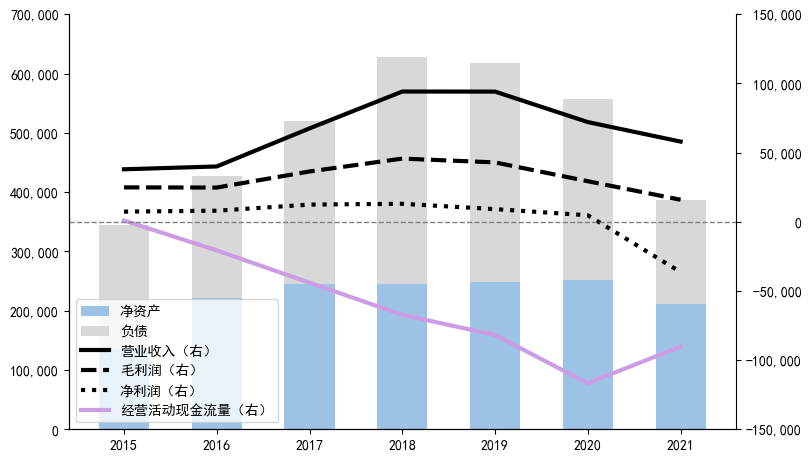

In [265]:
major_list = [
    Bar(TheSheet.loc[:, '所有者权益合计'], label='净资产', color=cm),
    Bar(TheSheet.loc[:, '负债合计'], TheSheet.loc[:, '所有者权益合计'], gray, '负债')
]
minor_list = [
    Line(TheSheet.loc[:, '营业总收入'], black, '营业收入（右）'),
    Line(TheSheet.loc[:, '营业总收入'] - TheSheet.loc[:, '营业成本'], black, '毛利润（右）', ls='--'),
    Line(TheSheet.loc[:, '净利润'], black, '净利润（右）', ls=':'),
    Line(TheSheet.loc[:, '经营活动产生的现金流量净额'], cl[1], '经营活动现金流量（右）')
]
Graphing(major_list, unit=1e4, minor_list=minor_list, xlist=xxx, minor_u=1e4, minor_f='{: >8,}')

### 3.2.    偿债能力

#### 偿债能力总览

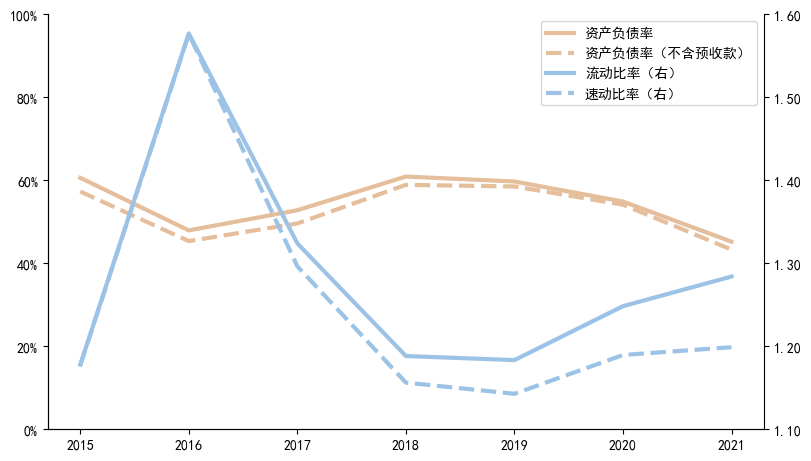

In [8]:
# 流&速动比率与资产负债率
cr = TheSheet.loc[:, '流动资产合计'] / TheSheet.loc[:, '流动负债合计']
qr = (TheSheet.loc[:, '流动资产合计'] - TheSheet.loc[:, '存货净额'])/ TheSheet.loc[:, '流动负债合计']
lev = TheSheet.loc[:, '负债合计'] / TheSheet.loc[:, '资产总计']
lev2 = (TheSheet.loc[:, '负债合计'] - TheSheet.loc[:, '预收款项'] - TheSheet.loc[:, '合同负债']) / TheSheet.loc[:, '资产总计']

Ncolor = neighborcolor(cm, 2, '-')

major_list = [
    Line(lev, Ncolor[1], '资产负债率'),
    Line(lev2, Ncolor[1], '资产负债率（不含预收款）', ls='--'),
]
minor_list = [
    Line(cr, cm, '流动比率（右）'),
    Line(qr, cm, '速动比率（右）', ls='--')
]
Graphing(major_list, '{:.0%}', xlist=xxx, minor_list=minor_list, ma_ylim_l=0, ma_ylim_u=1, save=path_img+'/2-1', minor_f='{:.2f}')

#### 债务的期限结构

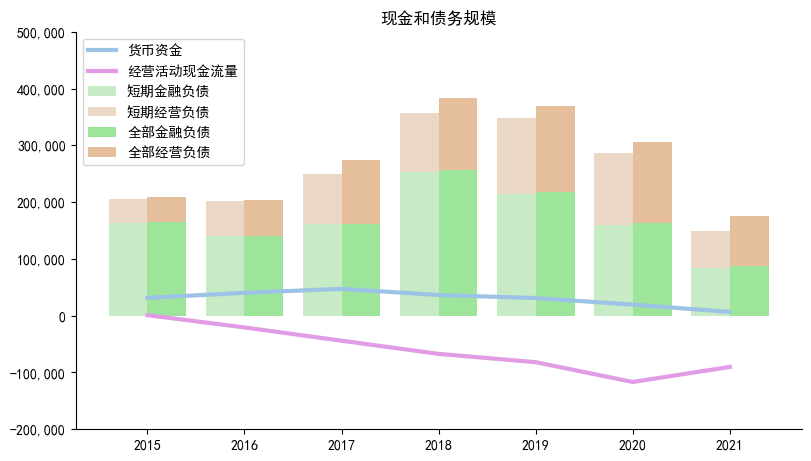

In [9]:
# 现金和债务规模
cash = TheSheet.loc[:, '货币资金']

# 短期金融负债
sfd = TheSheet.loc[:, '短期借款'] + TheSheet.loc[:, '一年内到期的非流动负债'] + TheSheet.loc[:, '应付利息'] + TheSheet.loc[:, '应付股利'] 
# 短期经营负债
sbd = TheSheet.loc[:, '流动负债合计'] - sfd

# 长期金融负债
lfd = TheSheet.loc[:, '长期借款'] + TheSheet.loc[:, '应付债券']
# 长期经营负债
lbd = TheSheet.loc[:, '非流动负债合计'] - lfd

#---------------------------------------------------------------------------#
Ncolor = neighborcolor(cm, 4, '-')
cn1l = degreecolor(Ncolor[1])[1]
cn2l = degreecolor(Ncolor[2])[1]

fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

ax.bar(x_coor - barwidth/2, sfd, barwidth, color=cn1l, label='短期金融负债')
ax.bar(x_coor - barwidth/2, sbd, barwidth, color=cn2l, label='短期经营负债', bottom=sfd)
ax.bar(x_coor + barwidth/2, sfd + lfd, barwidth, color=Ncolor[1], label='全部金融负债')
ax.bar(x_coor + barwidth/2, sbd + lbd, barwidth, color=Ncolor[2], label='全部经营负债', bottom=sfd + lfd)
ax.plot(x_coor, cash, color=cm, lw=3, label='货币资金')
ax.plot(x_coor, TheSheet.loc[:, '经营活动产生的现金流量净额'], color=Ncolor[-1], lw=3, label='经营活动现金流量')

ax.set_xticks(x_coor, xxx)

plt.title('现金和债务规模')
ax.legend()
ax.margins(x=0.05)

FormatTicks(ax, unit=1e4)

fig.savefig(path_img + '/2-2')

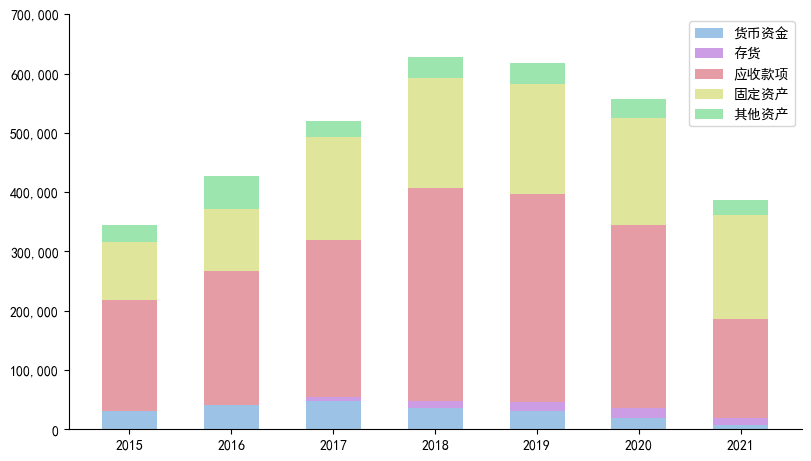

In [10]:
# 资产结构
ti = TheSheet.loc[:, '营业总收入']
gp = ti - TheSheet.loc[:, '营业成本']   # 毛利润
np = TheSheet.loc[:, '净利润']

gpr = gp / ti # 毛利率
npr = np / ti # 净利率

#---------------------------------------------------------------------------#
#x = TheSheet.loc[:, '会计期间']

lightc = degreecolor(cm, num=4)

cash = TheSheet.loc[:, '货币资金']
Inve = TheSheet.loc[:, '存货净额']
FixA = TheSheet.loc[:, '固定资产净额'] + TheSheet.loc[:, '在建工程净额'] + TheSheet.loc[:, '使用权资产'] + TheSheet.loc[:, '无形资产净额']
Accc = TheSheet.loc[:, '应收账款净额'] + TheSheet.loc[:, '其他应收款净额'] + TheSheet.loc[:, '合同资产'] + TheSheet.loc[:, '应收票据净额'] + TheSheet.loc[:, '应收款项融资']


major_list = [
    Bar(cash, 0, cl[0], '货币资金'),
    Bar(Inve, cash, cl[1], '存货'),
    Bar(Accc, cash + Inve, cl[2], '应收款项'),
    Bar(FixA, cash + Inve + Accc, cl[3], '固定资产'),
    Bar(TheSheet.loc[:, '资产总计'] - (cash + Inve + Accc + FixA), cash + Inve + Accc + FixA, cl[4], '其他资产')
    #Line(gp, Ncolor[-1], '毛利润')
]
Graphing(major_list, unit=1e4, xlist=xxx)

### 3.3.    盈利能力

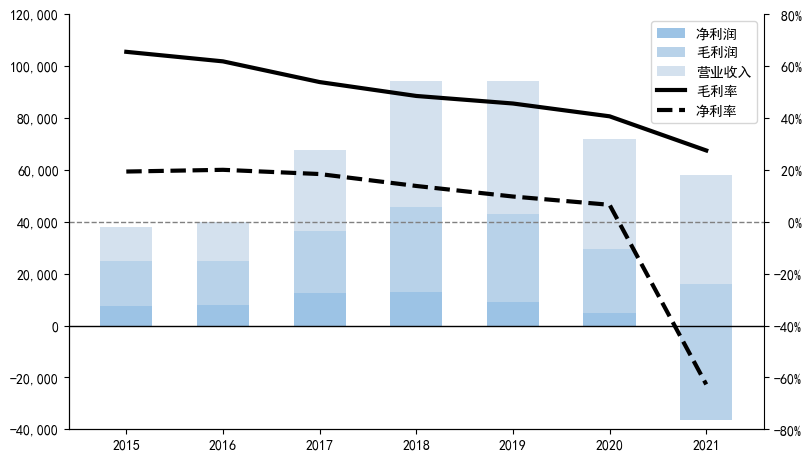

In [11]:
ti = TheSheet.loc[:, '营业总收入']
gp = ti - TheSheet.loc[:, '营业成本']   # 毛利润
np = TheSheet.loc[:, '净利润']

gpr = gp / ti # 毛利率
npr = np / ti # 净利率

#---------------------------------------------------------------------------#
#x = TheSheet.loc[:, '会计期间']

Ncolor = neighborcolor(cm, 4, '-')
lightc = degreecolor(cm, num=4)

major_list = [
    Bar(np, 0, lightc[0], '净利润'),
    Bar(gp - np, np, lightc[1], '毛利润'),
    Bar(ti - gp, gp, lightc[2], '营业收入')
]
minor_list = [
    Line(gpr, black, '毛利率'),
    Line(npr, black, '净利率', ls='--')
]
Graphing(major_list, unit=1e4, xlist=xxx, minor_list=minor_list, minor_f='{: >4.0%}')

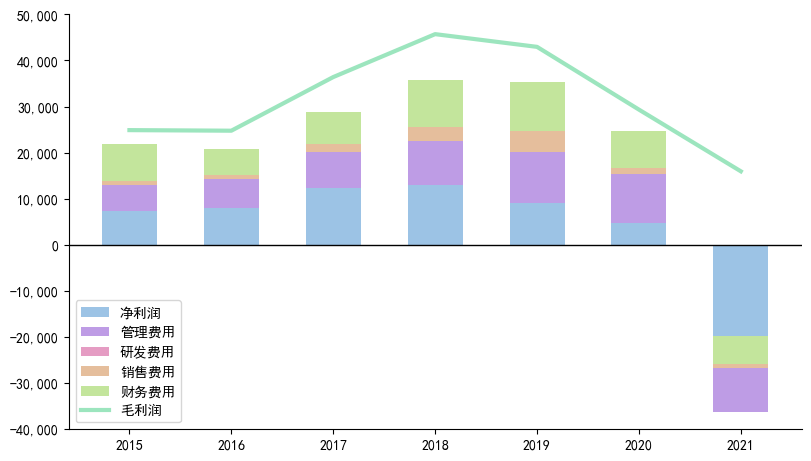

In [12]:
Ncolor = neighborcolor(cm, 6, '+')

c1 = TheSheet.loc[:, '管理费用']
c2 = TheSheet.loc[:, '研发费用']
c3 = TheSheet.loc[:, '销售费用']
c4 = TheSheet.loc[:, '财务费用']

major_list = [
    Bar(np, 0, Ncolor[0], '净利润'),
    Bar(c1, np, Ncolor[1], '管理费用'),
    Bar(c2, np + c1, Ncolor[2], '研发费用'),
    Bar(c3, np + c1 + c2, Ncolor[3], '销售费用'),
    Bar(c4, np + c1 + c2 + c3, Ncolor[4], '财务费用'),
    Line(gp, Ncolor[5], '毛利润')
]
Graphing(major_list, unit=1e4, xlist=xxx)

### 3.4.    周转能力/营运能力

In [13]:
应收 = TheSheet.loc[:, '应收账款净额'] + TheSheet.loc[:, '应收票据净额'] + TheSheet.loc[:, '应收款项融资'] + TheSheet.loc[:, '合同资产'] + TheSheet.loc[:, '其他应收款净额']
应付 = TheSheet.loc[:, '应付票据'] + TheSheet.loc[:, '应付账款'] + TheSheet.loc[:, '其他应付款']

# 应收账款
rtr = TheSheet.loc[:, '营业总收入'] / 应收.rolling(2).mean()
rtd = 360 / rtr

# 存货
itr = TheSheet.loc[:, '营业成本'] / TheSheet.loc[:, '存货净额'].rolling(2).mean()  # 存货周转率
itd = 360 / itr # 存货周转天数

# 占用客户资金（被占用以'-'号填列）：预收 - 应收
occ = (TheSheet.loc[:, '预收款项'] + TheSheet.loc[:, '合同负债']) - 应收
# 占用供应商资金（被占用以'-'号填列）：应付 - 预付
osc = 应付 - TheSheet.loc[:, '预付款项净额']

# 现金周转率1：应收周转率 + 存货周转率 - 应付周转率
ctr1 = rtr + itr - (TheSheet.loc[:, '营业成本'] / 应付.rolling(2).mean())

# 现金周转率2
ctr2 = TheSheet.loc[:, '营业总收入'] / TheSheet.loc[:, '货币资金'].rolling(2).mean()

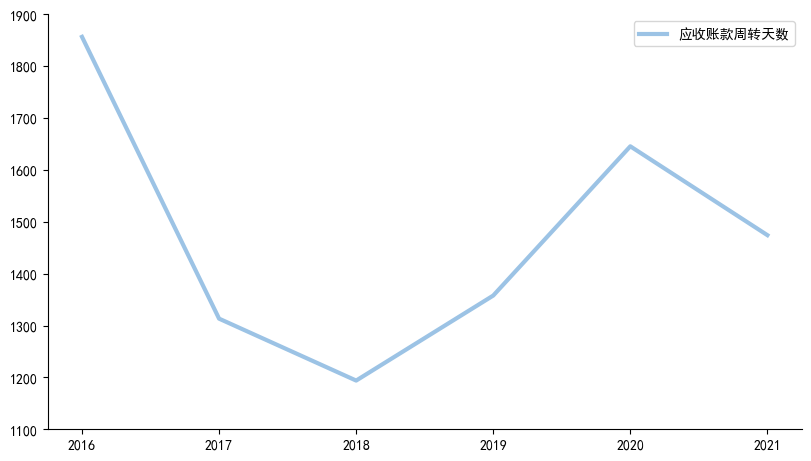

In [14]:
# 周转率 & 周转天数
Ncolor = neighborcolor(cm, 4, '-')

# major_list = [Line(rtr, cm, '应收账款周转率')]; minor_list = [Line(itr, Ncolor[2], '存货周转率（右轴）')];Graphing(major_list, format='{:.2f}', xlist=xxx, minor_list=minor_list, minor_f='{:.2f}')

# major_list = [Line(rtd, cm, '应收账款周转天数')]; minor_list = [Line(itd, Ncolor[2], '存货周转天数（右轴）')];Graphing(major_list, format='{:.0f}', xlist=xxx, minor_list=minor_list, minor_f='{:.0f}')

major_list = [Line(rtd, cm, '应收账款周转天数')]; 
#minor_list = [Line(rtr, Ncolor[2], '应收账款周转率（右轴）')];
Graphing(major_list, format='{:.0f}', xlist=xxx)

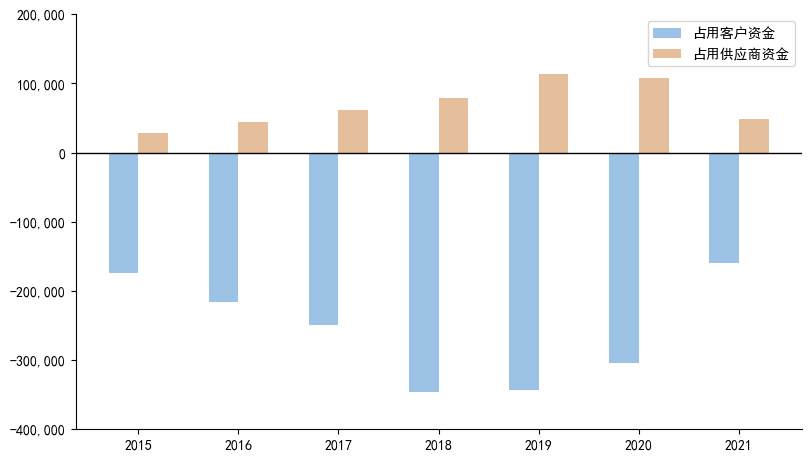

In [15]:
ml = [
    Bar(occ, 0, cm, '占用客户资金'),
    Bar(osc, 0, Ncolor[2], '占用供应商资金'),
]

Graphing(ml, unit=1e4, xlist=xxx, hor=True)